In [1]:
import cv2
import glob
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import torchvision
import sys
import yaml
import matplotlib.pyplot as plt
import time
import datetime as dt
import os
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from PIL import Image

c:\Users\User\anaconda3\envs\cv-python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append('C:/Users/jhsui/OneDrive/Desktop\AI6126 Adv Computer Vision/Projects/Project 2/BasicSR_Tutorial')

# from data.ffhqsub_dataset import FFHQsubDataset
from data.ffhqsub_dataset_trial import FFHQsubDataset
# from basicsr.archs.srresnet_arch import MSRResNet
# from basicsr.archs.srcnn_arch import SRCNNNet
from data.paired_image_dataset import PairedImageDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
with open('options/train_SRResNet_x4_FFHQ_300k.yml', 'r') as file:
    opt = yaml.load(file, Loader=yaml.FullLoader)

### Train set

In [4]:
# trainset = FFHQsubDataset(opt['datasets']['train'], degrees = [1,5])
trainset = FFHQsubDataset(opt['datasets']['train'], opt['realesrnet_config'])
train_loader = DataLoader(trainset, batch_size=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.5049993991851807


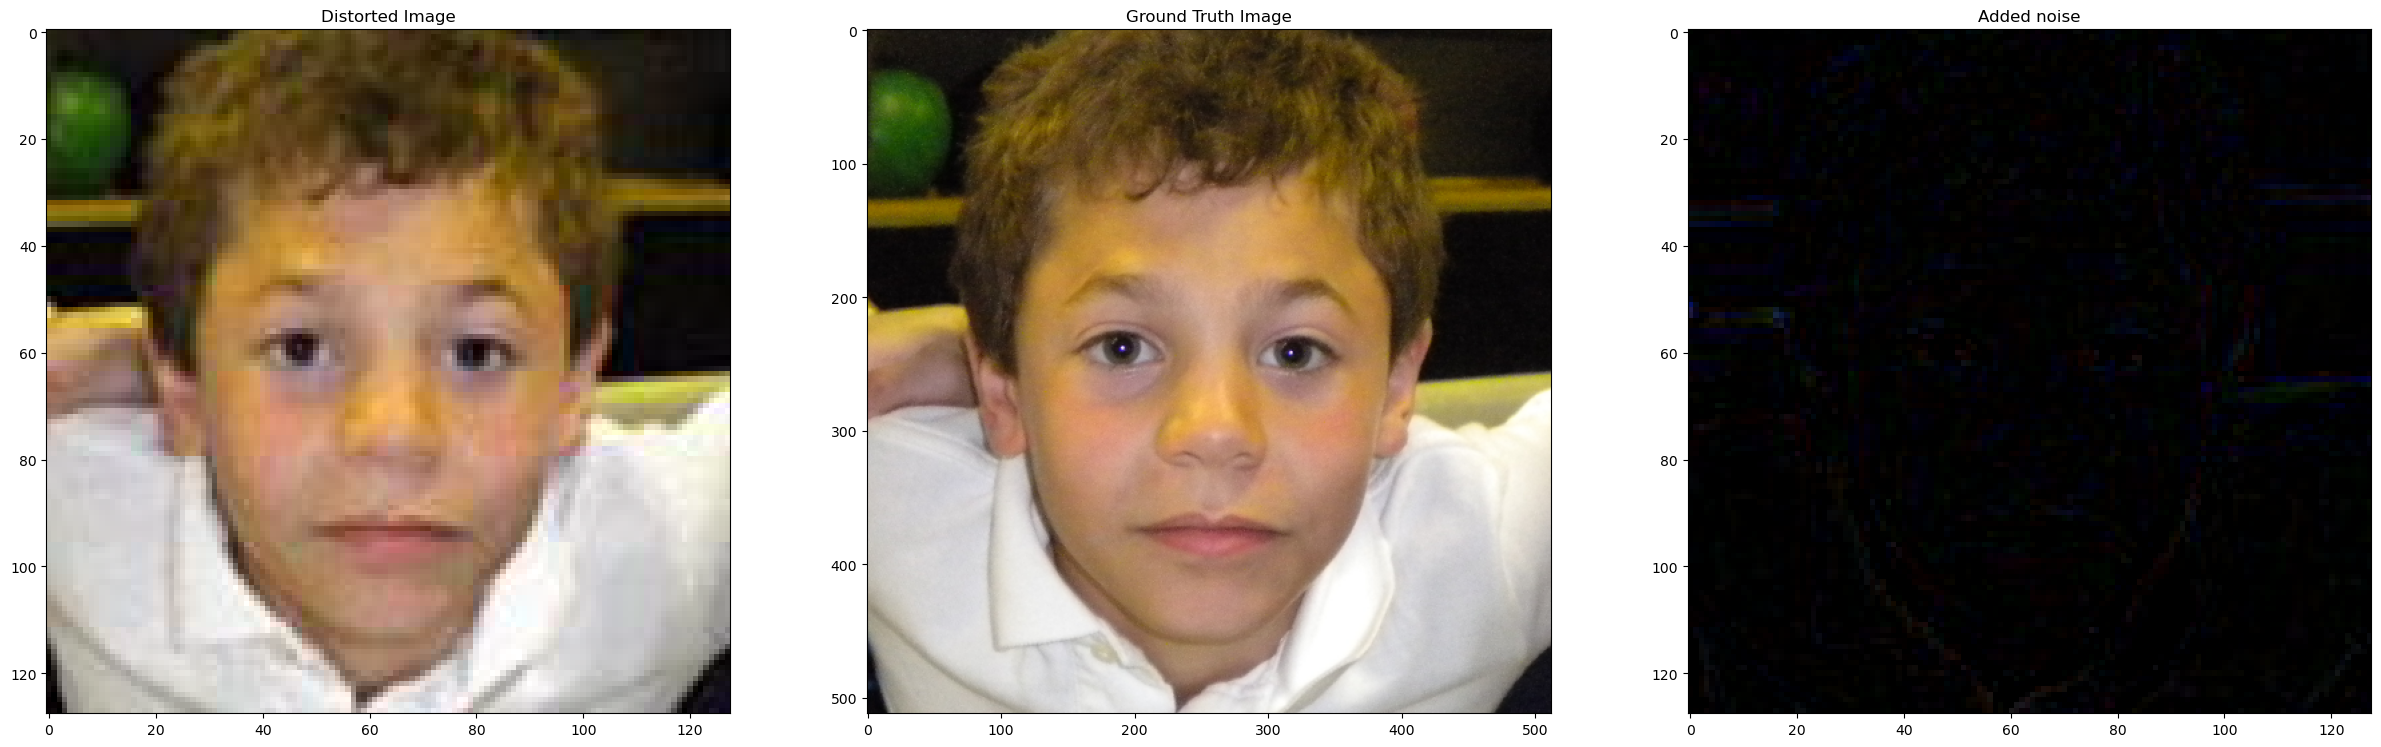

In [5]:
import time
from torchvision.transforms import Resize

start_time = time.time()
downsample = Resize(size = 128).to(device)

for idx, img in enumerate(train_loader):
    if idx == 0:

        lq = img['distorted_img'][0].to('cuda')
        ground_truth_img_tensor = img['gt'][0].to('cuda')
        noise = lq - downsample(ground_truth_img_tensor)

        end_time=time.time()
        print(end_time - start_time)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30,10))  

        ax1.imshow(lq.permute(1,2,0).detach().cpu().numpy())
        ax1.set_title('Distorted Image')

        ax2.imshow(ground_truth_img_tensor.permute(1,2,0).detach().cpu().numpy())
        ax2.set_title('Ground Truth Image')

        ax3.imshow(noise.permute(1,2,0).detach().cpu().numpy())
        ax3.set_title('Added noise')
        
        # plt.tight_layout()

        plt.show()
    else:
        break


### Val_set

In [6]:
valset = PairedImageDataset(opt['datasets']['val'])
val_loader = DataLoader(valset, batch_size=2)

['data/FFHQ/val/GT\\00000.png', 'data/FFHQ/val/GT\\00001.png'] ['data/FFHQ/val/LQ\\00000.png', 'data/FFHQ/val/LQ\\00001.png']


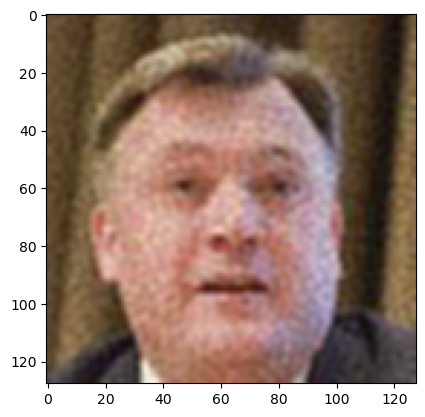

In [7]:
valset = PairedImageDataset(opt['datasets']['val'])
val_loader = DataLoader(valset, batch_size=2)

for idx, img in enumerate(val_loader):
    if idx == 0:
        print(img['gt_path'], img['lq_path'])
        img = img['lq'][1].permute(1,2,0)
        plt.imshow(img)
    else:
        break

### Model

In [8]:
import torch.nn as nn
from mmcv.runner import load_checkpoint

from mmedit.models.common import (PixelShufflePack, ResidualBlockNoBN,
                                  default_init_weights, make_layer)
from mmedit.models.registry import BACKBONES
from mmedit.utils import get_root_logger

c:\Users\User\anaconda3\envs\cv-python311\Lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [9]:
#Model

class SRResNet(nn.Module):
    def __init__(self, 
                in_channels = 3,
                out_channels = 3,
                hidden_channels = 64,
                n_blocks = 20,
                scale_factor = 4,
                p_dropout = 0.3):
        super(SRResNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = hidden_channels
        self.n_blocks = n_blocks
        self.scale_factor = scale_factor
        self.p_dropout = p_dropout

        self.conv1 = nn.Conv2d(self.in_channels, self.hidden_channels, 
                               kernel_size=3, stride = 1, padding = 1, bias = True)
        
        self.hidden_stack = make_layer(ResidualBlockNoBN, self.n_blocks,
                                       mid_channels = self.hidden_channels)
        

        # self.upsample = PixelShufflePack(self.hidden_channels, self.hidden_channels, 
        #                                  self.scale_factor,
        #                                  upsample_kernel = 3)

        self.upsample = nn.Sequential(
            nn.Conv2d(self.hidden_channels, self.hidden_channels*4, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.LeakyReLU(),
            nn.Conv2d(self.hidden_channels, self.hidden_channels*4, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.LeakyReLU()
        )
        
        self.conv_hr = nn.Conv2d(self.hidden_channels, self.hidden_channels,
                                 kernel_size = 3, stride = 1, padding = 1, bias = True)
        
        self.conv_out = nn.Conv2d(self.hidden_channels, self.out_channels,
                                  kernel_size = 3, stride = 1, padding = 1, bias = True)
        self.img_upsampler = nn.Upsample(scale_factor = self.scale_factor,
                                         mode = 'bilinear',
                                         align_corners = False)
        #activation
        self.activation = nn.LeakyReLU()

        #dropout
        self.dropout= nn.Dropout(p = self.p_dropout)

    def forward(self, x):
        x_org = x
        x = self.activation(self.conv1(x))
        x = self.hidden_stack(x)


        x = self.upsample(x)

        x = self.activation(self.conv_hr(x))

        feat = x

        x = self.dropout(x)

        out = self.conv_out(x)
        # print(out)
        upsampled_img = self.img_upsampler(x_org)
        out+= upsampled_img

        return out, feat

    def init_weights(self):
        for m in [self.conv1, self.conv_hr, self.conv_out]:
            default_init_weights(m, 0.1)
        

In [10]:
# class MSRResNet(nn.Module):
#     # _supported_upscale_factors = [2, 3, 4]

#     def __init__(self, in_channels=3, out_channels=3, mid_channels=64,
#                  num_blocks=16, upscale_factor=4, dropout_prob=0):

#         super().__init__()
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.mid_channels = mid_channels
#         self.num_blocks = num_blocks
#         self.upscale_factor = upscale_factor
#         self.dropout_prob = dropout_prob
#         self.conv_first = nn.Conv2d(in_channels, mid_channels, 3, 1, 1, bias=True)
#         self.trunk_net = make_layer(ResidualBlockNoBN, num_blocks, mid_channels=mid_channels)

#         # upsampling by x^2 twice to get 512
#         self.upsample1 = PixelShufflePack(mid_channels, mid_channels, 2, upsample_kernel=3)
#         self.upsample2 = PixelShufflePack(mid_channels, mid_channels, 2, upsample_kernel=3)
        
#         self.conv_hr = nn.Conv2d(mid_channels, mid_channels, 3, 1, 1, bias=True)
#         self.conv_last = nn.Conv2d(mid_channels, out_channels, 3, 1, 1, bias=True)

#         self.img_upsampler = nn.Upsample(
#             scale_factor=self.upscale_factor,
#             mode='bilinear',
#             align_corners=False)

#         # activation function
#         self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)

#         self.dropout_layer = nn.Dropout(p=self.dropout_prob)

#     def forward(self, x):
#         feat = self.lrelu(self.conv_first(x))
#         out = self.trunk_net(feat)
#         # print(f'initial shape: {out.shape}')
        
#         out = self.upsample1(out)
#         # print(f'upsample1 shape: {out.shape}')
#         out = self.upsample2(out)
#         # print(f'upsample2 shape: {out.shape}')
        
#         out = self.lrelu(self.conv_hr(out))
#         out = self.dropout_layer(out)
#         out = self.conv_last(out)
        
#         upsampled_img = self.img_upsampler(x)
#         out += upsampled_img
#         return out

#     def init_weights(self, pretrained=None, strict=True):
#         for m in [self.conv_first, self.conv_hr, self.conv_last]:
#             default_init_weights(m, 0.1)

In [11]:
def psnr(img1, img2):
    img1_detached = img1.cpu().detach()
    img2_detached = img2.cpu().detach()
    
    np_img1 = np.array(img1_detached)
    np_img2 = np.array(img2_detached)
    mse_value = np.mean((np_img1 - np_img2) ** 2)
    return 20. * np.log10(255. / np.sqrt(mse_value))

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [12]:
def train(epoch, epochs, iter, model, train_loader, optimizer, criterion, criterion_feats, batch_print, device,alphas):
    model.train()

    from torchvision.transforms import Resize

    train_loss = 0
    avg_train_loss = 0
    train_psnr = 0
    avg_train_psnr = 0

    with torch.no_grad():
        upsample = nn.Upsample(scale_factor=4, mode='bicubic', align_corners=False).to(device)
        downsample = Resize(size = 128).to(device)

    for idx, img in enumerate(train_loader):
        optimizer.zero_grad()
        data = img['distorted_img'].to(device)
        gt = img['gt'].to(device)
        # noise_img = img['noise'].to(device)
        # gt_noise = img['gt_noise'].to(device)
        # noise_img = data - downsample(gt)
        # noise_img = downsample(gt_noise)

        outputs,_ = model(data)
        # output_noise, _= model(noise_img)
        outputs_gt, _ = model(downsample(gt))

        # alpha = alphas[0]+((alphas[1]-alphas[0])/2)*(1+np.cos((5000*epoch+iter)/(5000*epochs)*np.pi)) #following cosine annealing            
        alpha = alphas[0]+((alphas[1]-alphas[0])/2)*(1+np.cos((5000*epoch+iter)/(5000*epochs)*np.pi)) #following cosine annealing

        loss = (1-alpha)*criterion(outputs, gt) + alpha*criterion_feats(outputs_gt, gt)
        
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss
        curr_psnr = psnr(outputs, gt)
        train_psnr += curr_psnr
        iter += batch_size

        if idx%batch_print == 0:
            print(f"Completed batch {idx}/{len(train_loader)}") 
            print(f"alpha: {alpha}")

        # if idx == 100:
        #     break

    avg_train_loss = train_loss / len(train_loader) 
    avg_train_psnr = train_psnr / len(train_loader)

    return avg_train_loss , avg_train_psnr

In [13]:
def val(epoch, epochs, iter, model, val_loader, criterion, criterion_feats, batch_print, device, alphas):
    model.eval()
    val_loss = 0
    val_psnr = 0

    from torchvision.transforms import Resize

    with torch.no_grad():
        upsample = nn.Upsample(scale_factor=4, mode='bicubic', align_corners=False).to(device)
        downsample = Resize(size = 128).to(device)
        for idx, img in enumerate(val_loader):
            iter += 2
            data = img['lq'].to(device)
            gt = img['gt'].to(device)
            # noise_img = data - downsample(gt)  
            # gt_noise = upsample(data) - gt

            outputs,_ = model(data)
            # output_noise, _= model(noise_img)
            outputs_gt, _ = model(downsample(gt))

            # alpha = alphas[0]+((alphas[1]-alphas[0])/2)*(1+np.cos((5000*epoch+iter)/(5000*epochs)*np.pi)) #following cosine annealing            
            alpha = alphas[0]+((alphas[1]-alphas[0])/2)*(1+np.cos((5000*epoch+iter)/(5000*epochs)*np.pi)) #following cosine annealing            

            loss = (1-alpha)*criterion(outputs, gt) + alpha*criterion_feats(outputs_gt, gt)   
            val_loss += loss
            val_psnr += psnr(outputs, gt)
            
            if idx%batch_print == 0:
                print(f"Completed batch {idx}/{len(val_loader)}")  

    avg_val_loss = val_loss / len(val_loader)
    avg_psnr = val_psnr / len(val_loader)
    
    return avg_val_loss, avg_psnr

In [14]:
model = SRResNet().to(device)

In [15]:
print(f"Model's trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad): ,}")
print(f"Model's total parameters: {sum(p.numel() for p in model.parameters()): ,}")

Model's trainable parameters:  1,812,995
Model's total parameters:  1,812,995


In [16]:
epochs = 10
batch_size = 5

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs)
criterion = nn.L1Loss(reduction='mean').to(device)
# criterion_feats = nn.MSELoss(reduction='mean').to(device)
criterion_feats = nn.L1Loss(reduction = 'mean').to(device)
train_batch_print = 500
val_batch_print = 50

best_valid_loss = float('inf')
best_valid_psnr = 0
iter = 0

for epoch in range(epochs):
    start_time = time.time()
    # alpha = 0.9*(1-((100*epoch)+iter)/(100*epochs))  #Change 100 later
    # alpha = 0.2
    alphas = [0.4, 0.8] #following cosine annealing

    if epoch%5 == 0:
        print('Performing new degrad')
        with open('options/train_SRResNet_x4_FFHQ_300k.yml', 'r') as file:
            opt = yaml.load(file, Loader=yaml.FullLoader)
        # trainset = FFHQsubDataset(opt['datasets']['train'], degrees = [1,5])
        trainset = FFHQsubDataset(opt['datasets']['train'], opt['realesrnet_config'])
        train_loader = DataLoader(trainset, batch_size=batch_size, shuffle = True)
        valset = PairedImageDataset(opt['datasets']['val'])
        val_loader = DataLoader(valset, batch_size=batch_size, shuffle = False)
        del trainset, valset



    train_loss, train_psnr = train(epoch, epochs, iter,model, train_loader, optimizer, criterion, criterion_feats, train_batch_print, device, alphas)
    val_loss, val_psnr = val(epoch, epochs, iter, model, val_loader, criterion, criterion_feats, val_batch_print, device, alphas)
    
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), 'Models/model_hr_best_loss.pt')
    if val_psnr > best_valid_psnr:
        best_valid_psnr = val_psnr
        torch.save(model.state_dict(), 'Models/model_hr_best_psnr.pt')
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | training loss: {train_loss:.3f} | val loss: {val_loss:.3f} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'train psnr: {train_psnr:.3f} | val psnr: {val_psnr:.3f} | Ending time: {dt.datetime.fromtimestamp(time.time())}')
    # torch.cuda.empty_cache()
    print('========'*10)

Performing new degrad
Completed batch 0/1000
alpha: 0.8
Completed batch 500/1000
alpha: 0.7975376681190276
Completed batch 0/80
Completed batch 50/80
Epoch: 01 | training loss: 0.072 | val loss: 0.023 | Epoch Time: 24m 57s
train psnr: 57.717 | val psnr: 73.322 | Ending time: 2024-04-25 18:18:39.304061
Completed batch 0/1000
alpha: 0.7902113032590308
Completed batch 500/1000
alpha: 0.7782013048376736
Completed batch 0/80
Completed batch 50/80
Epoch: 02 | training loss: 0.079 | val loss: 0.023 | Epoch Time: 24m 50s
train psnr: 57.142 | val psnr: 73.322 | Ending time: 2024-04-25 18:43:29.591511
Completed batch 0/1000
alpha: 0.7618033988749895
Completed batch 500/1000
alpha: 0.7414213562373095
Completed batch 0/80
Completed batch 50/80
Epoch: 03 | training loss: 0.088 | val loss: 0.024 | Epoch Time: 24m 44s
train psnr: 57.133 | val psnr: 73.323 | Ending time: 2024-04-25 19:08:14.331979
Completed batch 0/1000
alpha: 0.7175570504584947
Completed batch 500/1000
alpha: 0.6907980999479093
Compl

Epoch: 01 | training loss: 0.072 | val loss: 0.023 | Epoch Time: 24m 57s
train psnr: 57.717 | val psnr: 73.322 | Ending time: 2024-04-25 18:18:39.304061

Epoch: 02 | training loss: 0.079 | val loss: 0.023 | Epoch Time: 24m 50s
train psnr: 57.142 | val psnr: 73.322 | Ending time: 2024-04-25 18:43:29.591511

Epoch: 03 | training loss: 0.088 | val loss: 0.024 | Epoch Time: 24m 44s
train psnr: 57.133 | val psnr: 73.323 | Ending time: 2024-04-25 19:08:14.331979

Epoch: 04 | training loss: 0.101 | val loss: 0.025 | Epoch Time: 24m 46s
train psnr: 57.142 | val psnr: 73.320 | Ending time: 2024-04-25 19:33:00.478360

Epoch: 05 | training loss: 0.117 | val loss: 0.026 | Epoch Time: 24m 50s
train psnr: 57.117 | val psnr: 73.323 | Ending time: 2024-04-25 19:57:51.228273

Epoch: 06 | training loss: 0.130 | val loss: 0.027 | Epoch Time: 24m 59s
train psnr: 57.726 | val psnr: 73.322 | Ending time: 2024-04-25 20:22:50.628661

Epoch: 07 | training loss: 0.149 | val loss: 0.028 | Epoch Time: 25m 3s
train psnr: 57.128 | val psnr: 73.323 | Ending time: 2024-04-25 20:47:54.091349

Epoch: 08 | training loss: 0.163 | val loss: 0.029 | Epoch Time: 12m 7s
train psnr: 57.110 | val psnr: 73.322 | Ending time: 2024-04-25 21:00:01.371031

Epoch: 09 | training loss: 0.172 | val loss: 0.029 | Epoch Time: 12m 39s
train psnr: 57.128 | val psnr: 73.323 | Ending time: 2024-04-25 21:12:40.878713

Epoch: 10 | training loss: 0.178 | val loss: 0.030 | Epoch Time: 10m 42s
train psnr: 57.111 | val psnr: 73.322 | Ending time: 2024-04-25 21:23:23.832141

alpha = 0.9 ==> VAL PSNR: 73.468 (okay)

alpha = 0.8 ==> VAL PSNR: 73.470 (GOOD)

alpha = 0.7 ==> VAL PSNR: 73.469 (GOOD)

alpha = 0.6 ==> VAL PSNR: 73.449 (GOOD)

alpha = 0.5 ==> VAL PSNR: 73.430 (GOOD)

alpha = 0.4 ==> VAL PSNR: 73.463 (GOOD)

alpha = 0.3 ==> VAL PSNR: 73.349 (Okay)

alpha = 0.2 ==> VAL PSNR: 73.316 (unstable)

alpha = 0.1 ==> VAL PSNR: 73.438 (unstable)



In [28]:
def plot_loss(train_loss, val_loss, fig_name):
    x = np.arange(1, len(train_loss)+1)
    max_loss = max(max(train_loss), max(val_loss))

    fig, ax1 = plt.subplots()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_ylim([0,max_loss+0.3])
    lns1 = ax1.plot(x, train_loss, 'ro-', label='train_loss')
    lns2 = ax1.plot(x, val_loss, 'bo-', label='val_loss')
 
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)

    fig.tight_layout()
    plt.title(fig_name)


def plot_acc(train_acc, val_acc, fig_name):
    x = np.arange(1, len(train_acc)+1)
    max_psnr = max(max(train_acc), max(val_acc))

    fig, ax1 = plt.subplots()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_ylim([30,max_psnr + 5])

    lns1 = ax1.plot(x, train_acc, 'ro-', label = 'train_psnr')
    lns2 = ax1.plot(x, val_acc, 'bo-', label = 'val_psnr')

    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)

    fig.tight_layout()
    plt.title(fig_name)

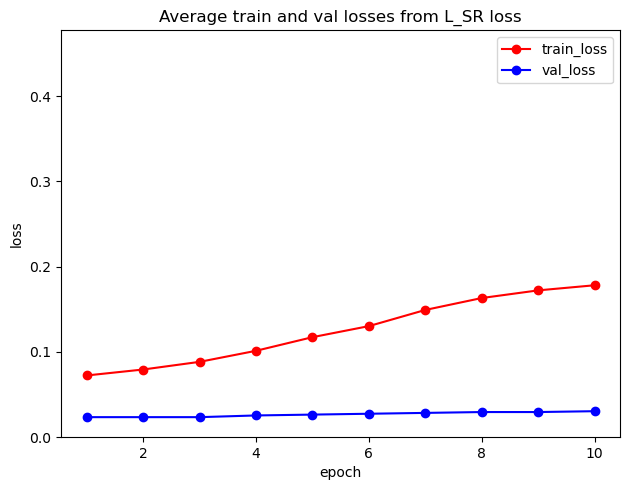

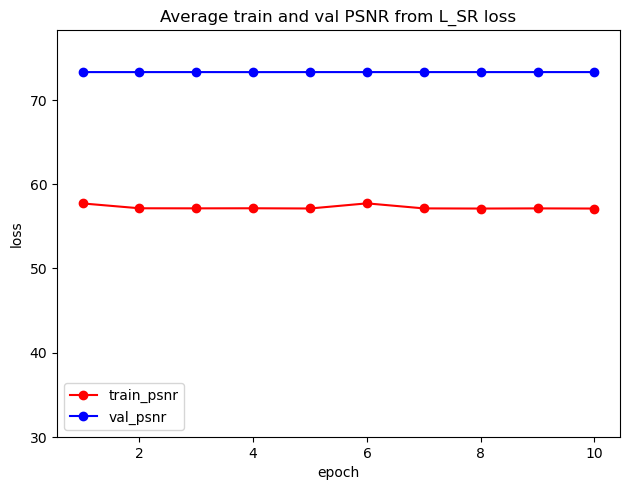

In [29]:
train_loss = [0.072, 0.079, 0.088, 0.101, 0.117, 0.130, 0.149, 0.163, 0.172, 0.178]
val_loss = [0.023, 0.023, 0.023, 0.025, 0.026, 0.027, 0.028, 0.029, 0.029, 0.030]
train_psnr = [57.717, 57.142, 57.133, 57.142, 57.117, 57.726, 57.128, 57.110, 57.128, 57.111]
val_psnr = [73.322, 73.322, 73.323, 73.320, 73.323, 73.322, 73.323, 73.322, 73.323, 73.322]

plot_loss(train_loss, val_loss, fig_name = 'Average train and val losses from L_SR loss')
plot_acc(train_psnr, val_psnr, fig_name = 'Average train and val PSNR from L_SR loss')

In [20]:
model.load_state_dict(torch.load('./Models/model_hr_best_psnr.pt'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


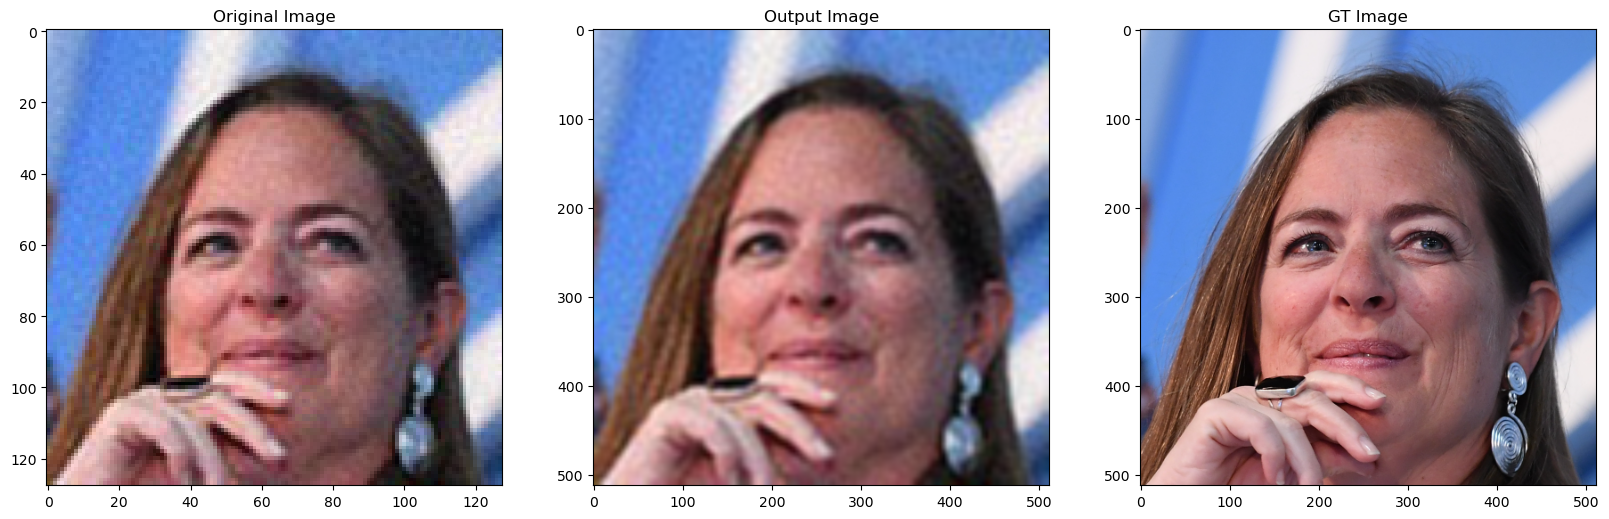

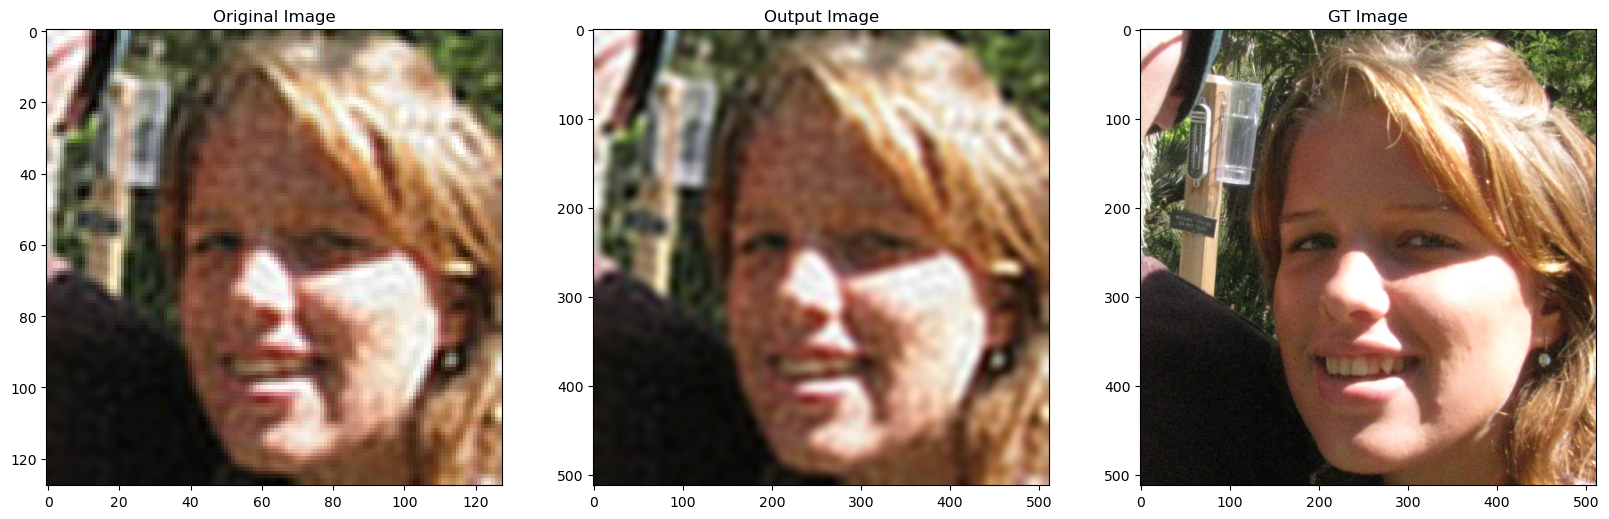

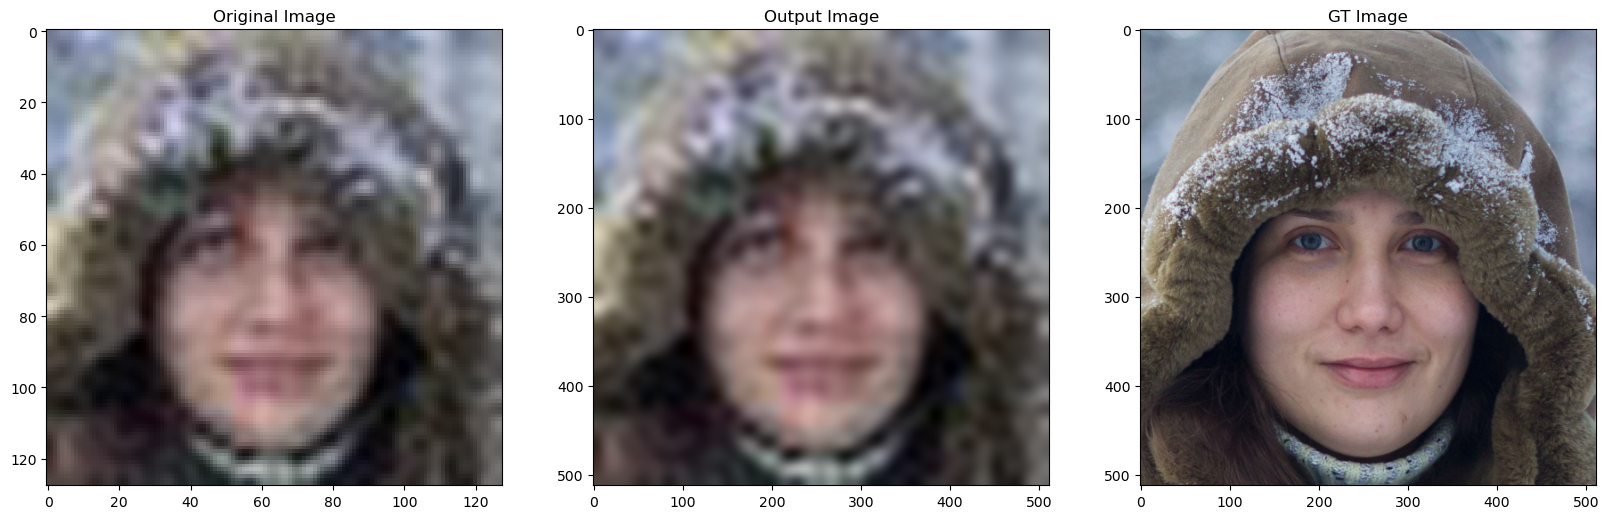

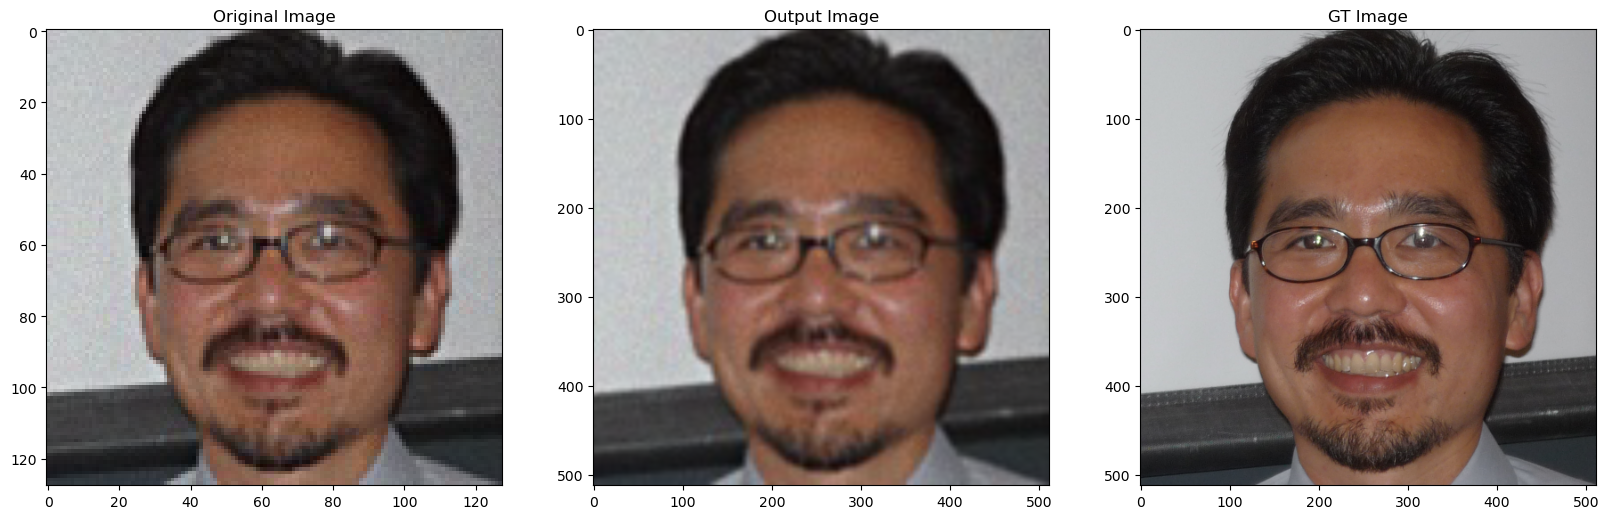

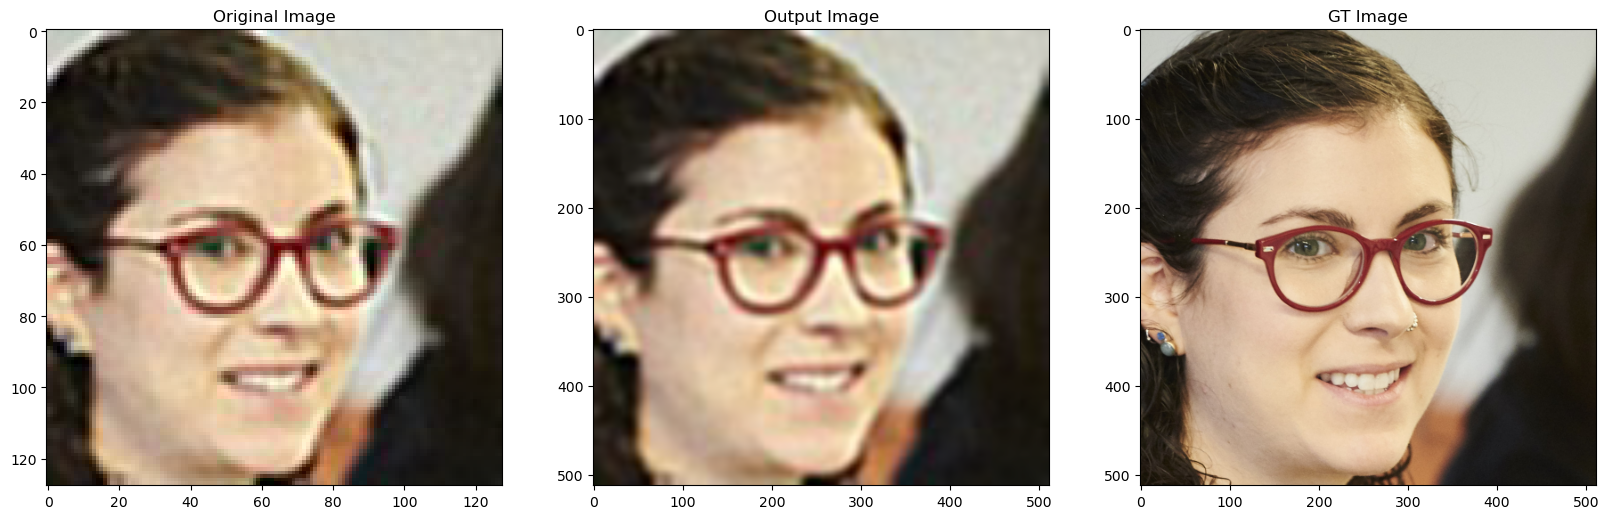

In [22]:
model = model
criterion = criterion
batch_print = val_batch_print

with open('options/train_SRResNet_x4_FFHQ_300k.yml', 'r') as file:
        opt = yaml.load(file, Loader=yaml.FullLoader)

valset = PairedImageDataset(opt['datasets']['val'])
val_loader = DataLoader(valset, batch_size=batch_size, shuffle = True)
model.eval()

with torch.no_grad():
    for idx, img in enumerate(val_loader):
        # print(idx)
        data, labels = img['lq'].to(device), img['gt'].to(device)
        outputs, _= model(data)

        for i in range(data.shape[0]):
            data_np = data[i].cpu()
            output_np = outputs[i].cpu()
            labels_np = labels[i].cpu()
            
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
            ax1.imshow(data_np.permute(1,2,0).numpy())
            ax1.set_title(f"Original Image")
            
            ax2.imshow(output_np.permute(1,2,0).numpy())
            ax2.set_title(f"Output Image")
    
            ax3.imshow(labels_np.permute(1,2,0).numpy())
            ax3.set_title(f"GT Image")
        break
        # if idx+1 >0:
        #     break

## With extreme alphas ==> look bright

### Saving test set

In [23]:
import os
from PIL import Image
from torch.utils.data import Dataset

class TestDataset(Dataset):
  def __init__(self, data_dir):
    self.data_dir = data_dir
    self.id = [img for img in os.listdir(data_dir)]
    # self.image_paths = [os.path.join(data_dir, img) for img in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, img))]

  def __len__(self):
    return len(self.id)

  def __getitem__(self, idx):
    # img_path = self.image_paths[idx]
    if os.path.isfile(os.path.join(self.data_dir, self.id[idx])):
        img_path = os.path.join(self.data_dir, self.id[idx]) 
        img = np.array(Image.open(img_path))/255.
    else:
      print("Error loading file")
    
    return {'img': torch.FloatTensor(img).permute(2,0,1), 
            'id': self.id[idx]}
  
testset = TestDataset(data_dir = "data/FFHQ/test/LQ") 
testset_real = TestDataset(data_dir="data/FFHQ/test_real")

In [24]:
def inference(model, model_type, testset, batch_size, device, test_type=None):
    if model_type == 'psnr':
        model.load_state_dict(torch.load("Models/model_hr_best_psnr.pt"))
    else:
        model.load_state_dict(torch.load("Models/model_hr_best_loss.pth"))

    model.to(device)

    test_loader = DataLoader(testset, batch_size)

    if test_type == 'real':
        output_folder_psnr = 'output/best_hr_psnr_real/'
        os.makedirs(output_folder_psnr, exist_ok=True)
        output_folder_loss = 'output/best_hr_loss_real/'
        os.makedirs(output_folder_loss, exist_ok=True)
    else:    
        output_folder_psnr = 'output/best_hr_psnr/'
        os.makedirs(output_folder_psnr, exist_ok=True)
        output_folder_loss = 'output/best_hr_loss/'
        os.makedirs(output_folder_loss, exist_ok=True)

    for batch in test_loader:
        imgs = batch['img'].to(device)
        ids = batch['id']

        out , _ = model(imgs)
        out = torch.clamp(out, min= 0.0, max=1.0)
        
        for idx, id in enumerate(ids):
            if model_type == 'psnr':
                save_image(out[idx], output_folder_psnr+id)  
            else:
                save_image(out[idx], output_folder_loss+id)
        
        # out = model_loss(imgs)

        

In [25]:
batch_size = 16
inference(model=SRResNet(), model_type = 'psnr', 
          testset = testset, 
          # testset=testset_real, test_type='real',
          batch_size=batch_size, device = 'cuda')

In [21]:
batch_size = 4
test_loader = DataLoader(testset, batch_size)

for batch in test_loader:
    imgs = batch['img'].to(device)
    ids = batch['id']
    out, _ =  model(imgs)

    out = torch.clamp(out, min= 0.0, max=1.0)
    
    for idx, id in enumerate(ids):
        save_image(out[idx], "output/trial/"+id)  

    del batch, imgs, ids, out